# phase

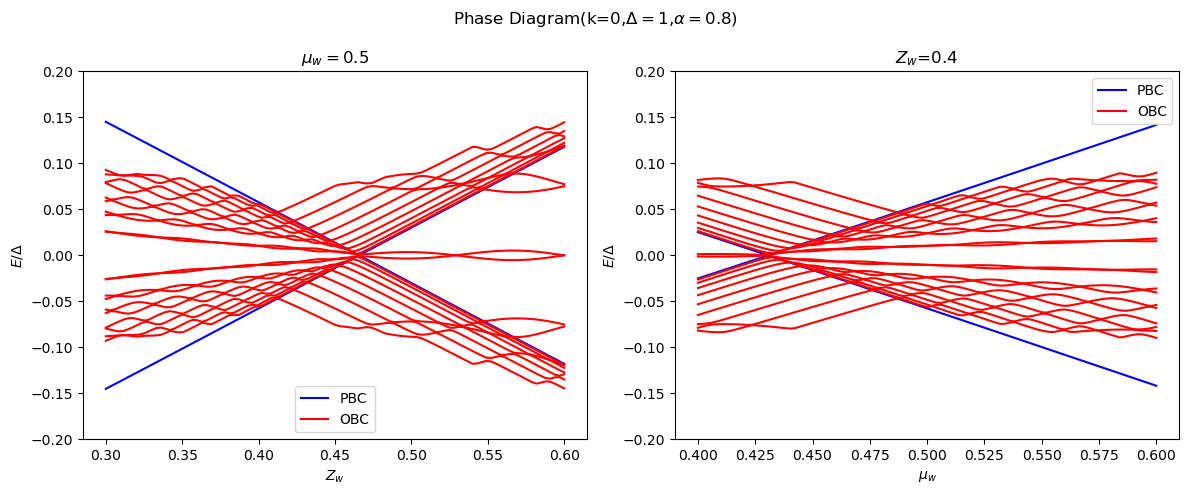

In [1]:
# %matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
import kwant
import time
from numpy import sqrt,pi,cos,sin,kron,min,abs
from scipy.sparse.linalg import eigsh
from full_system import *

#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z

L = 300
delta = 1
tw = 12
ts = 6
mu_s = 0.4
Zs = 0.
alpha = 0.8
T = 0.4


Zw_range = np.linspace(0.3, 0.6, 101)
mu_w_range = np.linspace(0.4, 0.6, 101)


def make_system_1D(L, delta, tw , ts, mu_w , mu_s, Zw, Zs, alpha, T, PBC=True):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    else:
        sys = kwant.Builder()
    
    lat_w = kwant.lattice.square(a=1, norbs=4, name='W')
    lat_s = kwant.lattice.square(a=1, norbs=4, name='SC')

    def W_region(pos):
        x, y = pos
        return 0 <= x <= L and y == 0
    def SC_region(pos):
        x, y = pos
        return 0 <= x <= L and y == -1


    def W_onsite(site):
        return (2 * tw - mu_w) * kron(tau_z, sigma_0) + Zw * kron(tau_0, sigma_x)
    
    def W_hop_x(site1, site2):
        return -tw * kron(tau_z, sigma_0) + 1j * alpha / 2 * kron(tau_z, sigma_y)

    def SC_onsite(site):
        return (2 * ts - mu_s) * kron(tau_z, sigma_0) + delta * kron(tau_x, sigma_0) + Zs * kron(tau_0, sigma_x)
    
    def SC_hop_x(site1, site2):
        return -ts * kron(tau_z, sigma_0) 


    '''add onsite and hopping'''
    # SC
    sys[lat_s.shape(SC_region, (0, -1))] = SC_onsite
    sys[kwant.builder.HoppingKind((1, 0), lat_s, lat_s)] = SC_hop_x

    # wire
    sys[lat_w.shape(W_region, (0, 0))] = W_onsite
    sys[kwant.builder.HoppingKind((1, 0), lat_w, lat_w)] = W_hop_x

    # Coupling 
    coupling_term = T * kron(tau_z, sigma_0) 
    sys[kwant.builder.HoppingKind((0, 1), lat_w, lat_s)] = coupling_term

    return sys

def compute_band_structure_pbc(param_range, Zw, mu_w, xlabel):
    E = []
    for param in param_range:
        sys = make_system_1D(L = L, delta = delta, tw = tw, ts = ts, mu_s = mu_s, Zs = Zs, alpha = alpha, T = T, PBC = True,
                   Zw = Zw if xlabel != 'B' else param, mu_w = mu_w if xlabel != '$\\mu$' else param).finalized()

        band_sys = kwant.physics.Bands(sys)
        E.append(band_sys(0))
    return E

def compute_band_structure_obc(param_range, Zw, mu_w, xlabel):
    E = []
    for param in param_range:
        sys = make_system_1D(L = L, delta = delta, tw = tw, ts = ts, mu_s = mu_s, Zs = Zs,  alpha = alpha, T = T, PBC = False,
                   Zw = Zw if xlabel != 'B' else param, mu_w = mu_w if xlabel != '$\\mu$' else param).finalized()
        
        ham = sys.hamiltonian_submatrix()
        eng = eigsh(ham, k=20, sigma=1e-10, return_eigenvectors=False)
        eng_sorted = np.sort(eng)
        E.append(eng_sorted)
    return E


# Compute data

mu_w_fix = 0.5
Zw_fix = 0.4

E_B_pbc = compute_band_structure_pbc(Zw_range, Zw=0, mu_w=mu_w_fix, xlabel='B')
E_B_obc = compute_band_structure_obc(Zw_range, Zw=0, mu_w=mu_w_fix, xlabel='B')
E_mu_pbc = compute_band_structure_pbc(mu_w_range, Zw=Zw_fix, mu_w=0, xlabel='$\\mu$')
E_mu_obc = compute_band_structure_obc(mu_w_range, Zw=Zw_fix, mu_w=0, xlabel='$\\mu$')


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Phase Diagram(k=0,$\\Delta={delta}$,$\\alpha={alpha}$)')

# Energy vs Magnetic Field
axes[0].plot(Zw_range, E_B_pbc, 'b')
axes[0].plot(Zw_range, E_B_obc, 'r')
axes[0].set_xlabel('$Z_w$')
axes[0].set_ylabel('$E/\\Delta$')
axes[0].set_ylim(-0.2,0.2)
# axes[0].set_xlim(0,)
axes[0].set_title(f'$\\mu_w={mu_w_fix}$')

axes[0].plot(Zw_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[0].plot(Zw_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[0].legend()

# Energy vs Chemical Potential
axes[1].plot(mu_w_range, E_mu_pbc, 'b')
axes[1].plot(mu_w_range, E_mu_obc, 'r')
axes[1].set_xlabel('$\\mu_w$')
axes[1].set_ylabel('$E/\\Delta$')
axes[1].set_ylim(-0.2,0.2)
# axes[1].set_xlim(0,)
axes[1].set_title(f'$Z_w$={Zw_fix}')

axes[1].plot(mu_w_range[0], E_B_pbc[0][0], 'b', label='PBC')  
axes[1].plot(mu_w_range[0], E_B_obc[0][0], 'r', label='OBC')
axes[1].legend()

plt.tight_layout()
plt.show()


# B,mu phase

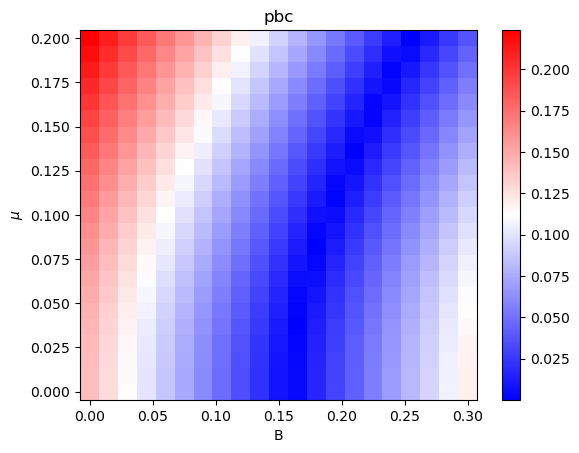

In [6]:
def compute_phase_pbc(B_range, mu_range):
    E = np.zeros((len(B_range),len(mu_range)))
    for i,Vw in enumerate(B_range):
        for j,mu_w in enumerate(mu_range):
            sys = make_system_1D(L=L, delta=delta, tw=tw, ts=ts, mu_s=mu_s, alpha=alpha, T=T, PBC=True, Vw=Vw, mu_w=mu_w).finalized()
            band_sys = kwant.physics.Bands(sys)
            E[i,j] = np.min(np.abs(band_sys(0)))
    return E

# Compute data
B_range = np.linspace(0, 0.3, 21)
mu_range = np.linspace(0, 0.2, 23)
E_pbc = compute_phase_pbc(B_range, mu_range)


X, Y = np.meshgrid(B_range, mu_range)
plt.figure()
plt.pcolormesh(X, Y, E_pbc.T, cmap='bwr', shading='auto') 
plt.title('pbc')
plt.xlabel('B')
plt.ylabel('$\\mu$')
cbar = plt.colorbar()  
# cbar.set_label('2e^2/h', fontsize=12) 
plt.show()